In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class OpticalSystem:

    def __init__(self, diameter, lambda0, RON, Npix, throughput, Nmodes):

        self.D = diameter
        self.lambda0 = lambda0
        self.RON = RON
        self.Npix = Npix
        self.tr = throughput
        self.Nmodes = Nmodes


    def sigma_tot(self, r0, V, mag, ts, rebin:int=0):
        fit_err = self.sigma_fit(r0,rebin)
        bw_err = self.sigma_bw(r0, V, ts)
        meas_err = self.sigma_meas(ts,mag,rebin)
        return np.sqrt(fit_err**2 + meas_err**2 + bw_err**2)

    def sigma_fit(self, r0, rebin:int = 0):
        N = self._Nmodes(rebin)
        sig_rad = np.sqrt(0.2944*N**(-np.sqrt(3)/2) * (self.D/r0)**(5/3))
        return self.rad2nm(sig_rad, self.lambda0)

    def sigma_bw(self, r0, Vwind, ts):
        sig_rad = (0.426 * Vwind /r0 / self._fc(ts) )**(5/6)
        return self.rad2nm(sig_rad, self.lambda0)

    def sigma_meas(self, ts, mag, rebin:int = 0):
        N = self._Nmodes(rebin)
        fs = 1/ts
        return self._chi(fs) * self._eta(N) * self.lambda0 / self._SNR(ts, mag, rebin)

    @staticmethod
    def rad2nm(sigma, lambda_ref):
        return sigma*lambda_ref/(2*np.pi)

    @staticmethod
    def _eta(N):
        a = 0.0536
        b = 0.0795
        return np.sqrt(2*(a+b*np.log(N)))

    @staticmethod
    def _fc(ts):
        fs = 1/ts
        return fs/10

    def _chi(self, ts):
        fc = self._fc(ts)
        fs = 1/ts
        return np.sqrt(2*fc/fs)*np.arctan(fs/(2*fc))

    def _flux(self, mag):
        B0 = 1e+10 # photons / m^2 / s
        return self.tr*B0*10**(-mag/2.5)

    @staticmethod
    def _Nphot(phi, ts, d):
        return phi*ts*d**2

    def _SNR(self, ts, mag, rebin:int = 0):
        d = self._subap_size(rebin)
        phi = self._flux(mag)
        Nph = self._Nphot(phi, ts, d)
        SNR = Nph/np.sqrt(Nph+self.Npix*self.RON**2)
        return SNR

    def _subap_size(self, rebin:int = 0):
        N = self._Nmodes(rebin)
        area = np.pi*self.D**2/4
        return np.sqrt(area/N)

    def _Nmodes(self, rebin:int=0):
        N = self.Nmodes
        if rebin > 0:
            N /= 4*rebin
        return np.round(N)


def SR(sigma, lam):
    mareshal = 2*np.pi/lam*sigma
    return np.exp(-mareshal**2)

def r0_in_l0(r0, l0):
    return r0*(l0/500e-9)**(6/5)

In [3]:
l0 = 800e-9
thrp = 0.11
EKARUS = OpticalSystem(diameter=1.8, lambda0=l0, RON=1, Npix=4, throughput=thrp, Nmodes = 468)

r0 = 5e-2 # @ 500 nm
r0_800 = r0_in_l0(r0,l0)

V = 10

ts = 1e-3
mag = 9

print(EKARUS.sigma_bw(r0_800, V, ts)*1e+9)
print(EKARUS.sigma_fit(r0_800)*1e+9)
print(EKARUS.sigma_meas(ts, mag)*1e+9)
print(EKARUS.sigma_tot(r0_800, V, mag, ts)*1e+9)
print(SR(EKARUS.sigma_tot(r0_800, V, mag, ts),lam=1400e-9)*100)

69.63428675883965
59.69355145181631
799.0468272183552
804.2935322785228
0.00021942899623240164


Text(0, 0.5, 'Strehl ratio')

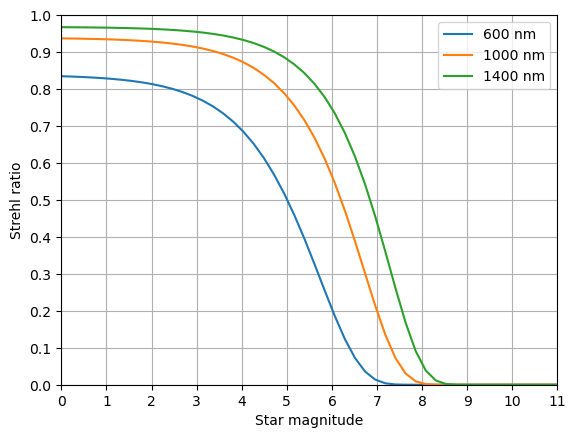

In [4]:
mag_vec = np.linspace(0,11)

r0 = 0.1 # @ 500 nm
V = 5

r0_800 = r0_in_l0(r0,l0)

SR600 = SR(EKARUS.sigma_tot(r0_800,V,mag_vec,ts), lam=600e-9)
SR1000 = SR(EKARUS.sigma_tot(r0_800,V,mag_vec,ts), lam=1000e-9)
SR1400 = SR(EKARUS.sigma_tot(r0_800,V,mag_vec,ts), lam=1400e-9)

plt.figure()
plt.plot(mag_vec, SR600)
plt.plot(mag_vec, SR1000)
plt.plot(mag_vec, SR1400)
plt.grid()
plt.ylim([0,1])
plt.xlim([0,11])
plt.yticks(ticks=np.arange(0,1.1,0.1))
plt.xticks(ticks=np.arange(0,12,1))
plt.legend(('600 nm','1000 nm','1400 nm'))
plt.xlabel('Star magnitude')
plt.ylabel('Strehl ratio')

In [5]:

from scipy.optimize import minimize


def find_best_ts(opt_sys,r0,V,mag,bin,max_freq=2000):
    log_loss = lambda x,r0,V,mag,bin: np.log(1-SR(opt_sys.sigma_tot(r0,V,mag,x,rebin=bin),lam=800e-9))
    optout = minimize(log_loss, x0=1e-3, bounds = [(1/max_freq,1)], args = (r0,V,mag,bin))
    best_ts = optout.x[0]
    return best_ts


def find_best_pars(opt_sys,r0,V,mag,max_freq=2000):

    flag = 1
    bin = 0

    best_ts = find_best_ts(opt_sys,r0,V,mag,bin,max_freq)
    best_SR = SR(opt_sys.sigma_tot(r0,V,mag,best_ts,rebin=bin),lam=800e-9)
    best_bin = bin

    while flag:
        bin += 1
        _ts = find_best_ts(opt_sys,r0,V,mag,bin,max_freq)
        _SR = SR(opt_sys.sigma_tot(r0,V,mag,_ts,rebin=bin),lam=800e-9)

        if _SR >= best_SR:
            best_ts = _ts
            best_SR = _SR
            best_bin = bin
        else:
            flag = 0

    return best_ts, best_bin, best_SR


In [6]:
mag = 8
V = 10
r0 = r0_in_l0(5e-2,l0)
ts_opt, bin_opt, SR_opt = find_best_pars(EKARUS,r0,V,mag)

print(1/ts_opt)
print(bin_opt)
print(SR_opt)

723.897807395504
1
0.13828282442396847


In [7]:
print(SR(EKARUS.sigma_tot(r0,V,mag,1/2000,rebin=0),lam=800e-9))
print(SR(EKARUS.sigma_tot(r0,V,mag,1/1460,rebin=0),lam=800e-9))
print(SR(EKARUS.sigma_tot(r0,V,mag,1/1460,rebin=1),lam=800e-9))
print(SR(EKARUS.sigma_tot(r0,V,mag,1/2000,rebin=2),lam=800e-9))

1.8296541950117822e-12
8.321072269306627e-08
0.0730825147432431
0.09396402967484749


In [26]:
def plot_SR_vs_mag(magV,SRvec,legend_str:str = None):

    if len(np.shape(SRvec)) == 1:
        plt.plot(magV,SRvec,'-o')
    else:
        for i in range(np.shape(SRvec)[1]):
            plt.plot(magV,SRvec[:,i],'-o')
    plt.grid()
    plt.xlim([min(magV),max(magV)])
    plt.yticks(ticks=np.arange(0,1.1,0.1))
    plt.ylim([0,1])
    plt.xlabel('Guide star magnitude')
    plt.ylabel('Strehl ratio')

    if legend_str is not None:
        plt.legend(legend_str)


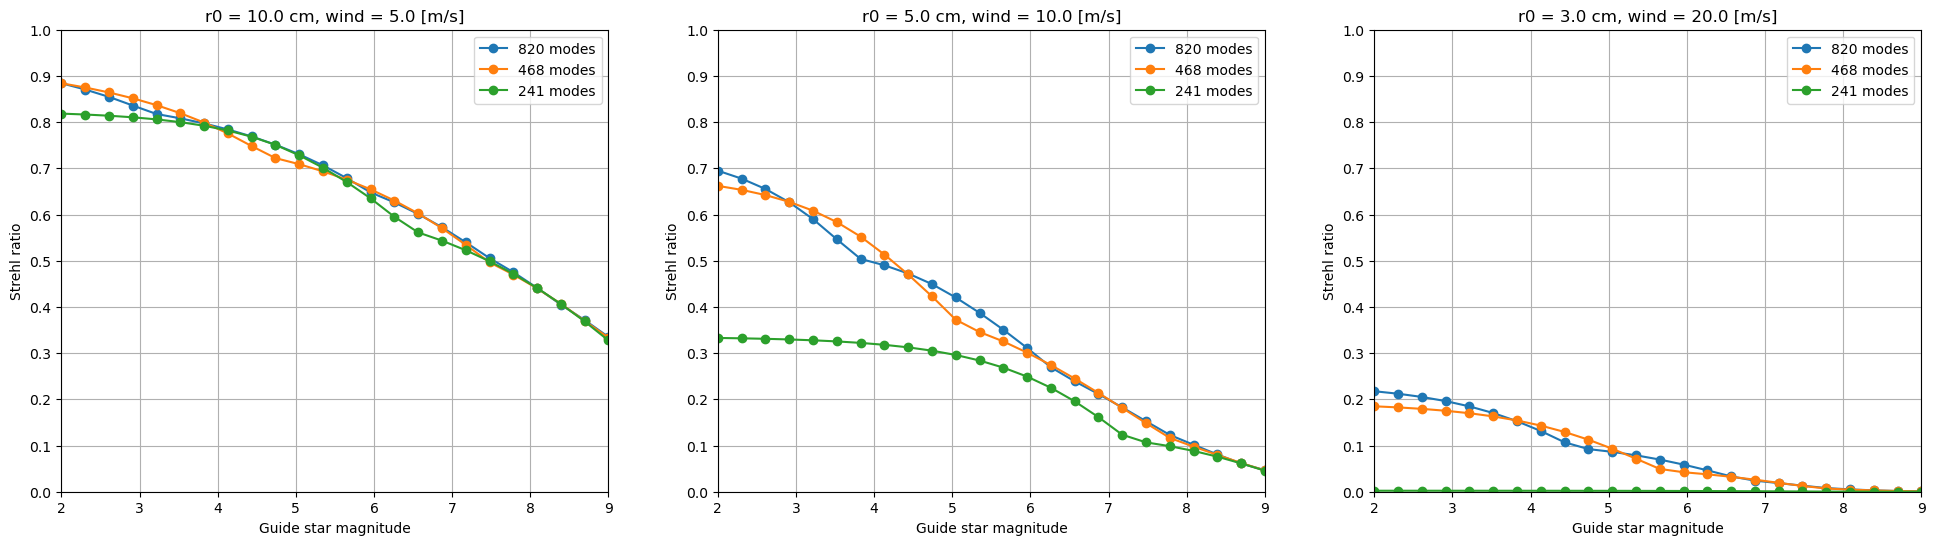

In [27]:
# Define different dm systems
l0 = 1000e-9
thrp = 0.11
dm820 = OpticalSystem(diameter=1.8, lambda0=l0, RON=1, Npix=4, throughput=thrp, Nmodes = 819)
dm468 = OpticalSystem(diameter=1.8, lambda0=l0, RON=1, Npix=4, throughput=thrp, Nmodes = 467)
dm241 = OpticalSystem(diameter=1.8, lambda0=l0, RON=1, Npix=4, throughput=thrp, Nmodes = 240)

# Set maximum frequency and magnitude range
magV = np.linspace(2,9,24)
maxF = 1500
maxF241 = 600

# Define best, median, worst obervation conditions
Vvec = np.array([5,10,20])
r0vec = np.array([10,5,3])*1e-2

# Perform the cycle
plt.figure(figsize=(24,6))
for j in range(len(Vvec)):
    r0 = r0vec[j]
    V = Vvec[j]
    r800 = r0_in_l0(r0,l0)

    SRvec = np.zeros([len(magV),3])
    for k,mag in enumerate(magV):
        _, _, SRvec[k,0] = find_best_pars(dm820,r800,V,mag,max_freq=maxF)
        _, _, SRvec[k,1] = find_best_pars(dm468,r800,V,mag,max_freq=maxF)
        _, _, SRvec[k,2] = find_best_pars(dm241,r800,V,mag,max_freq=maxF241)

    plt.subplot(1,len(Vvec),j+1)
    plt.title(f'r0 = {r0*1e+2:1.1f} cm, wind = {V:1.1f} [m/s]')
    plot_SR_vs_mag(magV, SRvec, legend_str = ('820 modes', '468 modes', '241 modes'))

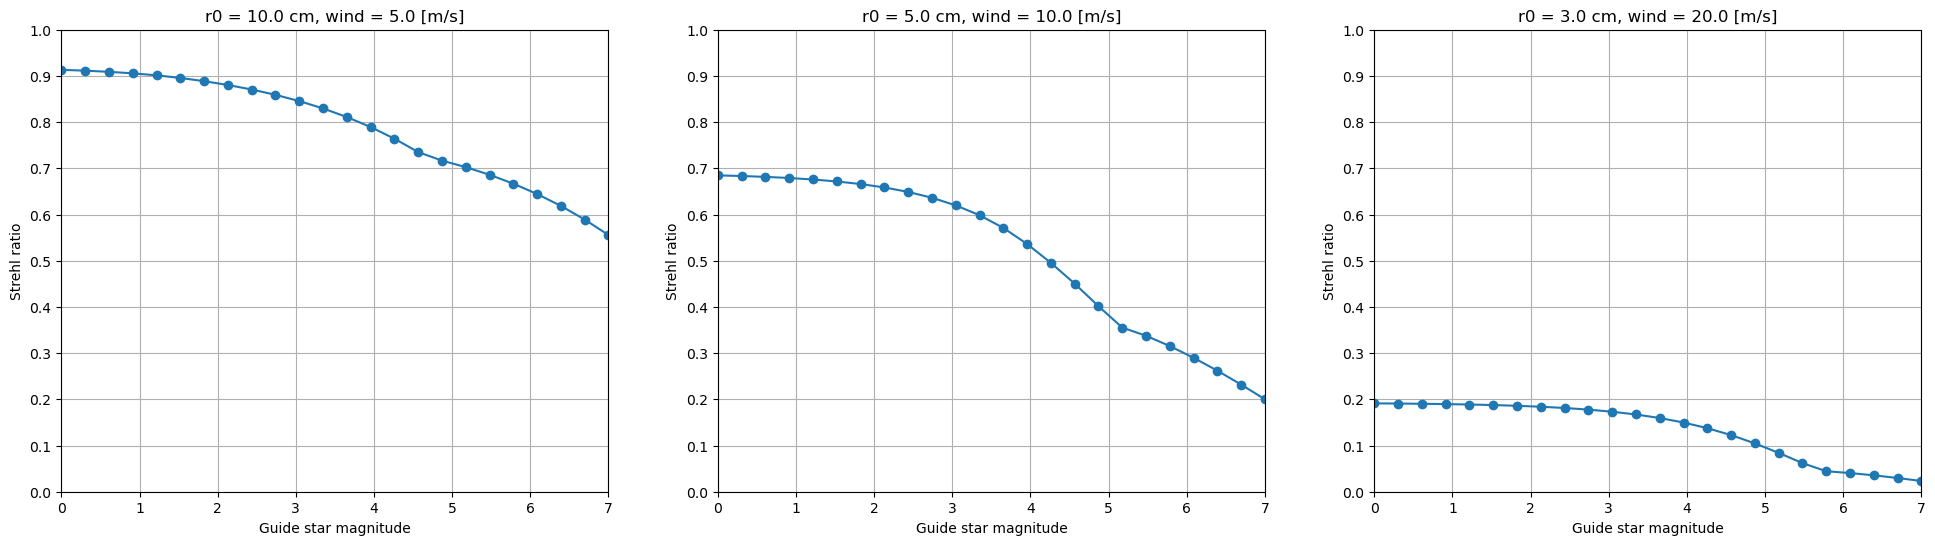

In [29]:
l0 = 1000e-9
thrp = 0.11
dm468 = OpticalSystem(diameter=1.8, lambda0=l0, RON=1, Npix=4, throughput=thrp, Nmodes = 467)

# Set maximum frequency and magnitude range
magVec = np.linspace(0,7,24)
maxF = 1500

# Define best, median, worst obervation conditions
Vvec = np.array([5,10,20])
r0vec = np.array([10,5,3])*1e-2

SRvec = np.zeros([len(magV),3])

# Perform the cycle
plt.figure(figsize=(24,6))
for j in range(len(Vvec)):
    r0 = r0vec[j]
    V = Vvec[j]
    rl0 = r0_in_l0(r0,l0)

    for k,mag in enumerate(magVec):
        _, _, SRvec[k,j] = find_best_pars(dm468,rl0,V,mag,max_freq=maxF)

    plt.subplot(1,len(Vvec),j+1)
    plt.title(f'r0 = {r0*1e+2:1.1f} cm, wind = {V:1.1f} [m/s]')
    plot_SR_vs_mag(magVec, SRvec[:,j])

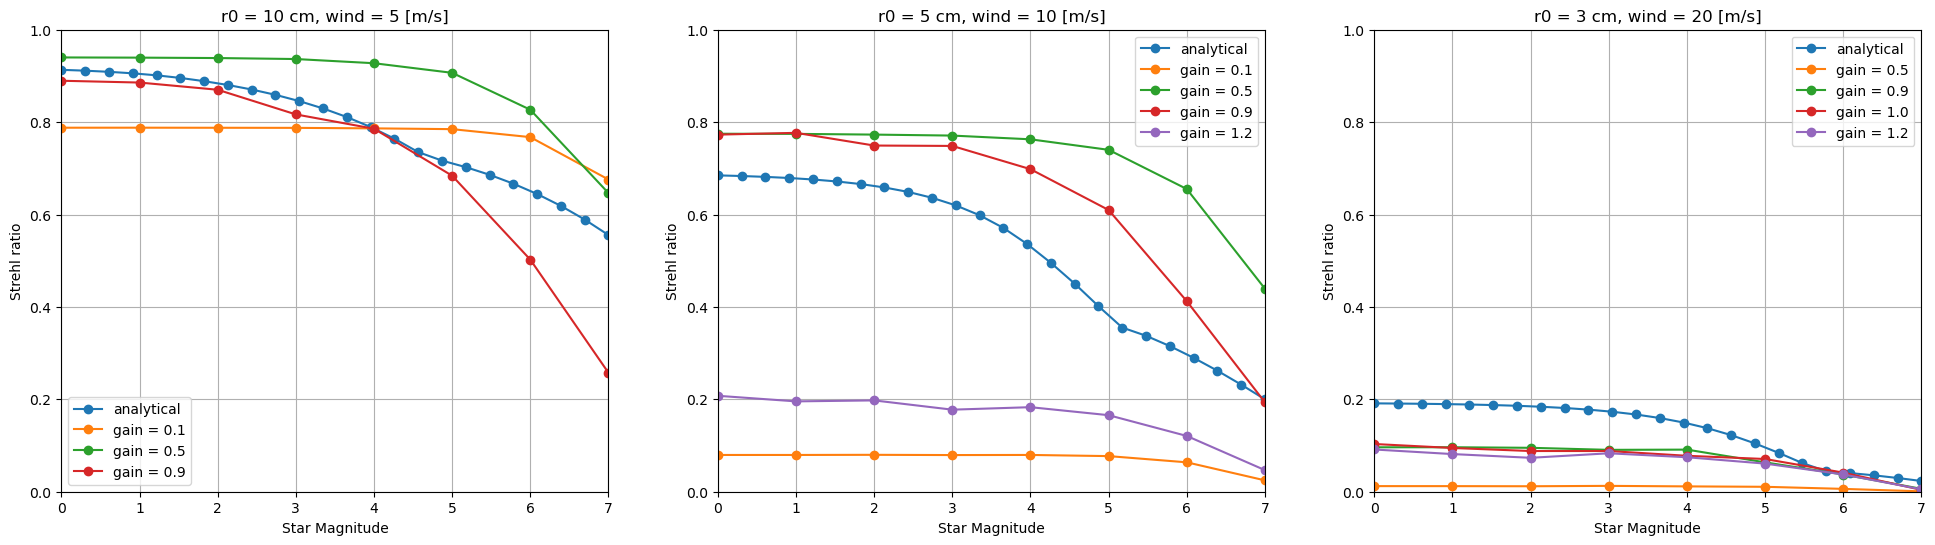

In [31]:
# Good conditions, magnitudes 0-7:
gSR_g09 = np.array([0.88956527, 0.88565285, 0.87006295, 0.81668884, 0.78566329, 0.68396727, 0.50234195, 0.25748424]) 
gSR_g05 = np.array([0.94000352, 0.93957176, 0.93869515, 0.93655578, 0.9274898 , 0.90669278, 0.82683848, 0.64644262])
gSR_g01 = np.array([0.78789731, 0.78795236, 0.78777981, 0.78757668, 0.78650057, 0.78479575, 0.76752886, 0.67577056])

# Median conditions, magnitudes 0-7:
mSR_g12 = np.array([0.20763226, 0.19556244, 0.19766102, 0.17760802, 0.18298931, 0.16566745, 0.12071678, 0.04674659])
mSR_g09 = np.array([0.77293039, 0.77677631, 0.74929967, 0.74846034, 0.69816368, 0.60976921, 0.41245413, 0.1934763])
mSR_g05 = np.array([0.77484928, 0.77456325, 0.77298759, 0.77088001, 0.76278976, 0.74002127, 0.65520551, 0.4394291])
mSR_g01 = np.array([0.07955603, 0.07957647, 0.07987661, 0.07934589, 0.07959753, 0.07709809, 0.06365888, 0.0246024])

# Bad conditions, magnitudes 0-7:
bSR_g09 = np.array([0.09616258, 0.09628217, 0.09505093, 0.09062196, 0.09113182, 0.06355759, 0.03723595, 0.00626951])
bSR_g05 = np.array([0.01212847, 0.01208906, 0.01183113, 0.01267279, 0.01154288, 0.01065876, 0.00614681, 0.00081655])
bSR_g10 = np.array([0.09140501, 0.08149479, 0.07342348, 0.08318994, 0.07465894, 0.06087203, 0.03739284, 0.00521037])
bSR_g095 = np.array([0.10328166, 0.09467429, 0.08808178, 0.08809803, 0.07775582, 0.07083318, 0.04130607, 0.00399716])
bSR_g12 = np.array([0.0434135, 0.04109255, 0.042189, 0.04362013, 0.03909143, 0.02995943, 0.01900699, 0.00282347])


# Define best, median, worst obervation conditions
magV = np.arange(8)

# Perform the cycle
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.title(f'r0 = 10 cm, wind = 5 [m/s]')
plt.plot(magVec, SRvec[:,0], '-o', label='analytical')
plt.plot(magV, gSR_g01, '-o', label='gain = 0.1')
plt.plot(magV, gSR_g05, '-o', label='gain = 0.5')
plt.plot(magV, gSR_g09, '-o', label='gain = 0.9')
plt.ylabel('Strehl ratio')
plt.xlabel('Star Magnitude')
plt.xlim([0,7])
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1,3,2)
plt.title(f'r0 = 5 cm, wind = 10 [m/s]')
plt.plot(magVec, SRvec[:,1], '-o', label='analytical')
plt.plot(magV, mSR_g01, '-o', label='gain = 0.1')
plt.plot(magV, mSR_g05, '-o', label='gain = 0.5')
plt.plot(magV, mSR_g09, '-o', label='gain = 0.9')
plt.plot(magV, mSR_g12, '-o', label='gain = 1.2')
plt.ylabel('Strehl ratio')
plt.xlabel('Star Magnitude')
plt.xlim([0,7])
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1,3,3)
plt.title(f'r0 = 3 cm, wind = 20 [m/s]')
plt.plot(magVec, SRvec[:,2], '-o', label='analytical')
plt.plot(magV, bSR_g05, '-o', label='gain = 0.5')
plt.plot(magV, bSR_g09, '-o', label='gain = 0.9')
plt.plot(magV, bSR_g095, '-o', label='gain = 1.0')
plt.plot(magV, bSR_g10, '-o', label='gain = 1.2')
plt.ylabel('Strehl ratio')
plt.xlabel('Star Magnitude')
plt.xlim([0,7])
plt.ylim([0,1])
plt.grid()
plt.legend()

In [ ]:
# Plot WFE budget
def plot_wfe_budget(opt_sys, mag_vec, r0_vec, V_vec):

    plt.figure(figsize=(24,6))
    for j in range(len(V_vec)):
        r0 = r0_vec[j]
        V = V_vec[j]
        r800 = r0_in_l0(r0,l0)

        fit_err = np.zeros(len(mag_vec))
        bw_err = np.zeros(len(mag_vec))
        meas_err = np.zeros(len(mag_vec))
        tot_err = np.zeros(len(mag_vec))

        for k,mag in enumerate(mag_vec):
            ts, bin, _ = find_best_pars(opt_sys,r800,V,mag,max_freq=2000)

            fit_err[k] = opt_sys.sigma_fit(r0, bin)
            bw_err[k] = opt_sys.sigma_bw(r0, V, ts)
            meas_err[k] = opt_sys.sigma_meas(ts, mag, bin)
            tot_err[k] = opt_sys.sigma_tot(r0, V, mag, ts, bin)

        plt.subplot(1,len(V_vec),j+1)
        plt.title(f'r0 = {r0*1e+2:1.1f} cm, wind = {V:1.1f} [m/s]')
        plt.plot(magV,fit_err*1e+9,'-o',label='fitting')
        plt.plot(magV,bw_err*1e+9,'-o',label='bandwidth')
        plt.plot(magV,meas_err*1e+9,'-o',label='measurement')
        plt.plot(magV,tot_err*1e+9,'--',label='total')
        plt.grid()
        plt.xlim([min(magV),max(magV)])
        plt.xlabel('Guide star magnitude')
        plt.ylabel('Error [nm]')
        plt.legend()


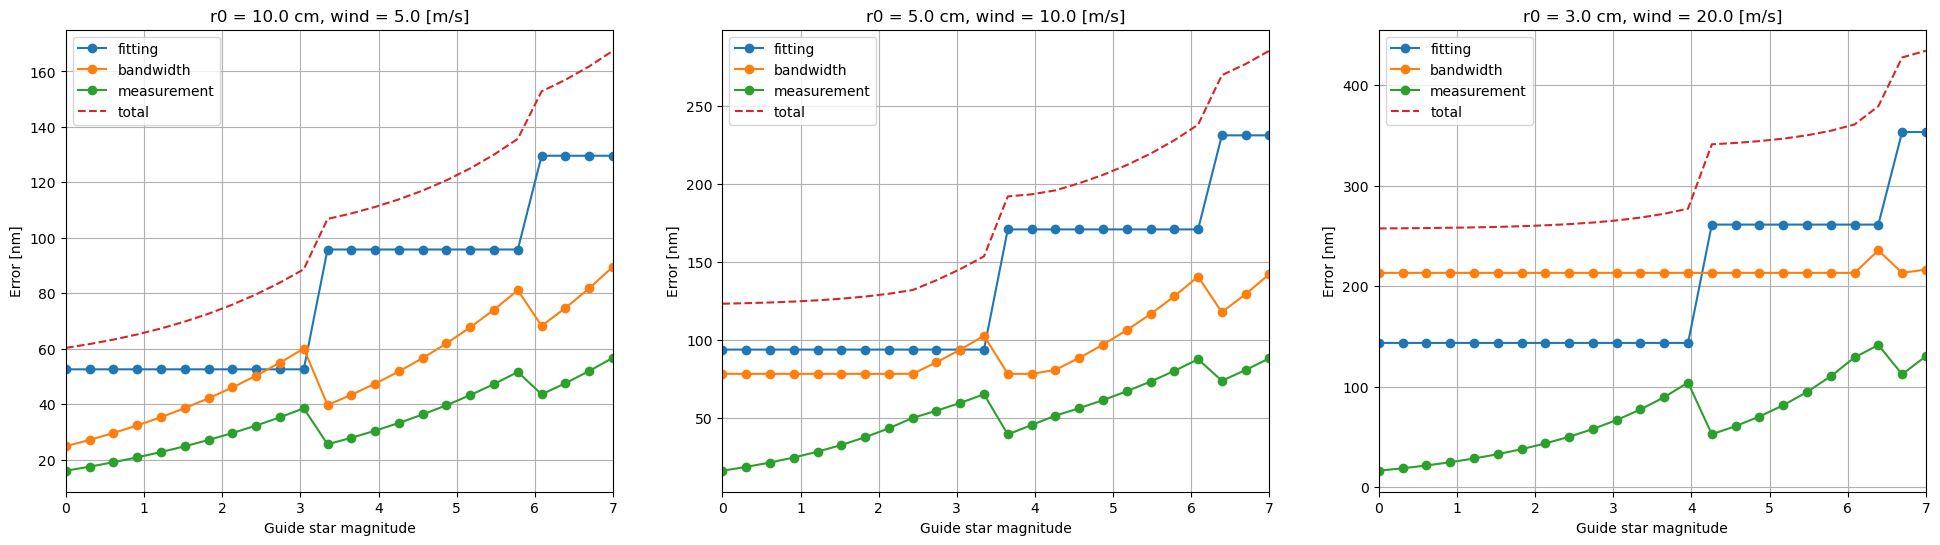

In [13]:
plot_wfe_budget(dm820, magV, r0vec, Vvec)

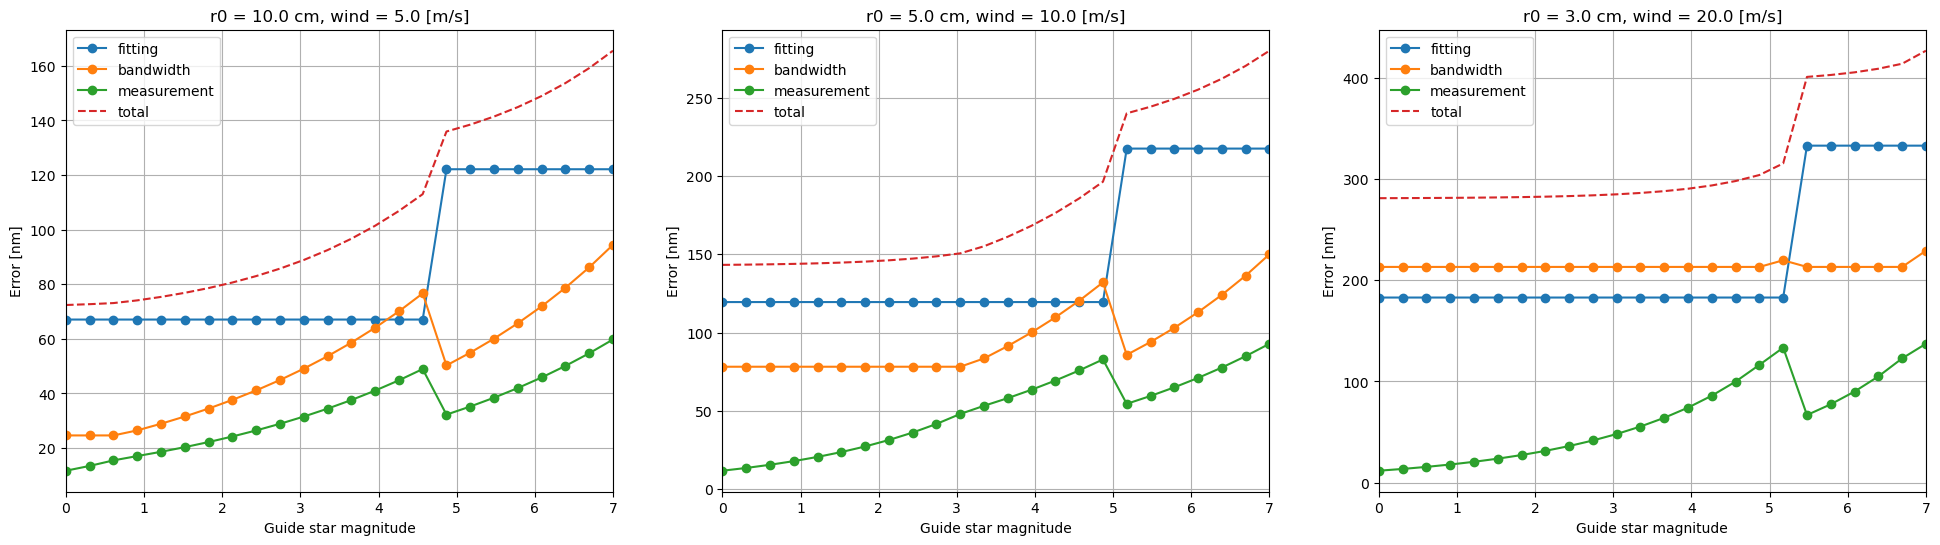

In [14]:
plot_wfe_budget(dm468, magV, r0vec, Vvec)